Quick analysis

In [1]:
#!/usr/bin/env python3
import os
import json
import h5py
import argparse
import pandas as pd
import numpy as np
import tinydb as db
from tinydb.storages import MemoryStorage
import matplotlib.pyplot as plt
# plt.style.use('../clint.mpl')
import matplotlib as mpl
from matplotlib.colors import LogNorm

import boost_histogram as bh
import pickle as pl

from pygama import DataGroup
import pygama.lh5 as lh5
import pygama.analysis.histograms as pgh
import pygama.analysis.peak_fitting as pgf
import cage_utils
plt.rcParams['figure.figsize'] = [14, 10]

In [2]:
run = 64 #44 #70 #64
dsp_id = '02'
user = True
hit =True
cal = True
lowE=False
etype = 'trapEftp_cal'

corr_DCR=True
corr_AoE=True
corr_ToE=True

norm = True
cut = True


dsp_list = ['energy', 'trapEftp', 'trapEmax', 'trapEftp_cal', 'bl','bl_sig', 'bl_slope', 'AoE', 'dcr', "tp_0", "tp_02", "tp_05", "tp_10", "tp_20", "tp_30", "tp_40", "tp_50", "tp_60", "tp_70", "tp_80", "tp_90", "tp_96", 'tp_max', 'ToE', 'log_tail_fit_slope', 'wf_max', 'wf_argmax', 'trapE_argmax', 'lf_max']

df_raw, dg, runtype, rt_min, radius, angle_det, rotary = cage_utils.getDataFrame(run, user=user, hit=hit, cal=cal, dsp_list=dsp_list, lowE=lowE)

df = cage_utils.apply_DC_Cuts(run, df_raw)

if 'dcr' in dsp_list and corr_DCR==True:
    if run>57:
        const, offset, err = cage_utils.corrDCR(df, etype, e_bins=300, elo=0, ehi=6000, dcr_fit_lo=-30, dcr_fit_hi=40)
        df['dcr_plot'] = df['dcr']-offset + ((-1*const))*df[etype]
    elif corr_DCR==True and run<57:
        const = const = 0.0011
        df['dcr_plot'] = df['dcr'] - const*df['trapEftp']
else:
    df['dcr_plot'] = df['dcr']
    
if 'AoE' in dsp_list and corr_AoE==True:
    AoE_mode = cage_utils.mode_hist(df, param='AoE', a_bins=1000, alo=0.005, ahi=0.075, cut=False, cut_str='')
    df['AoE_plot'] = df['AoE'] - AoE_mode
else:
    df['AoE_plot'] = df['AoE']

if 'ToE' in dsp_list and corr_ToE==True:
    ToE_mode = cage_utils.mode_hist(df, param='ToE', a_bins=1000, alo=0.30, ahi=0.45, cut=False, cut_str='')
    df['ToE_plot'] = df['ToE'] - ToE_mode
else:
    df['ToE_plot'] = df['ToE']

Radius: 7.5; Angle: 90; Rotary: 0.0
user: True; cal: True; hit: True
Using hit files
loading data for /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc869_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc870_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc871_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc872_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc873_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc874_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc875_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc876_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc877_hit.lh5 /global/project/projectdirs/legend/users/gothman/CAGE//hit/cage_run64_cyc878_hit.lh5
No options specified for cut selection! Using de

In [3]:
with open('./analysis_60keV.json') as f:
        params = json.load(f)

In [4]:
mean_60 = params[str(run)]['mean_60']
sig_60 = params[str(run)]['sig_60']
chiSquare_fit_60 = params[str(run)]['chiSquare_fit_60']
cut_60_3sig = params[str(run)]['cut_60_3sig']
bkg_60_left = params[str(run)]['bkg_60_left']
bkg_60_right = params[str(run)]['bkg_60_right']
bkg_60 = params[str(run)]['bkg_60']

In [5]:

cut_60_3sig = f'({mean_60-3*sig_60} <= trapEftp_cal <= {mean_60+3*sig_60})'
cut_60_left = f'({mean_60-3*sig_60} <= trapEftp_cal < {mean_60})'
cut_60_right = f'({mean_60} <= trapEftp_cal < {mean_60+3*sig_60})'


bkg_60_left_min = mean_60-7.*sig_60
bkg_60_left_max = mean_60-4*sig_60

bkg_60_right_min = mean_60+4*sig_60
bkg_60_right_max = mean_60+7.*sig_60

bkg_60_left = f'({mean_60-7.*sig_60} <= trapEftp_cal < {mean_60-4*sig_60})'
bkg_60_right = f'({mean_60+4*sig_60} < trapEftp_cal <= {mean_60+7.*sig_60})'


counts_peak = len(df.query(cut_60_3sig).copy())
err_peak = np.sqrt(counts_peak)

left_counts = len(df.query(bkg_60_left))
right_counts = len(df.query(bkg_60_right))

total_bkg = len(df.query(bkg_60).copy())
err_bkg = np.sqrt(total_bkg)


counts = counts_peak - total_bkg
err = np.sqrt(counts_peak + total_bkg)
print(f'bkg_subtracted counts: {counts}')
print(f'error: {err}')
print(f'{(err/counts)*100:.3f}%')


bkg_subtracted counts: 4234
error: 136.10290224679267
3.215%


In [6]:
df_60 = df.query(cut_60_3sig).copy()
df_bkg = df.query(bkg_60).copy()

In [7]:
# Create all the timepoint parameters!

df['tp0010'] = df['tp_10'] - df['tp_0']
df['tp0020'] = df['tp_20'] - df['tp_0']
df['tp0030'] = df['tp_30'] - df['tp_0']
df['tp0040'] = df['tp_40'] - df['tp_0']
df['tp0050'] = df['tp_50'] - df['tp_0']
df['tp0060'] = df['tp_60'] - df['tp_0']
df['tp0070'] = df['tp_70'] - df['tp_0']
df['tp0080'] = df['tp_80'] - df['tp_0']
df['tp0090'] = df['tp_90'] - df['tp_0']
df['tp0096'] = df['tp_96'] - df['tp_0']

df['tp0205'] = df['tp_05'] - df['tp_02']
df['tp0210'] = df['tp_10'] - df['tp_02']
df['tp0220'] = df['tp_20'] - df['tp_02']
df['tp0250'] = df['tp_50'] - df['tp_02']


df['tp0510'] = df['tp_10'] - df['tp_05']
df['tp0520'] = df['tp_20'] - df['tp_05']
df['tp0550'] = df['tp_50'] - df['tp_05']

df['tp1020'] = df['tp_20'] - df['tp_10']
df['tp1030'] = df['tp_30'] - df['tp_10']
df['tp1040'] = df['tp_40'] - df['tp_10']
df['tp1050'] = df['tp_50'] - df['tp_10']
df['tp1060'] = df['tp_60'] - df['tp_10']
df['tp1070'] = df['tp_70'] - df['tp_10']
df['tp1080'] = df['tp_80'] - df['tp_10']
df['tp1090'] = df['tp_90'] - df['tp_10']
df['tp1096'] = df['tp_96'] - df['tp_10']

df['tp2030'] = df['tp_30'] - df['tp_20']
df['tp2040'] = df['tp_40'] - df['tp_20']
df['tp2050'] = df['tp_50'] - df['tp_20']
df['tp2060'] = df['tp_60'] - df['tp_20']
df['tp2070'] = df['tp_70'] - df['tp_20']
df['tp2080'] = df['tp_80'] - df['tp_20']
df['tp2090'] = df['tp_90'] - df['tp_20']
df['tp2096'] = df['tp_96'] - df['tp_20']

df['tp3040'] = df['tp_40'] - df['tp_30']
df['tp3050'] = df['tp_50'] - df['tp_30']
df['tp3060'] = df['tp_60'] - df['tp_30']
df['tp3070'] = df['tp_70'] - df['tp_30']
df['tp3080'] = df['tp_80'] - df['tp_30']
df['tp3090'] = df['tp_90'] - df['tp_30']
df['tp3096'] = df['tp_96'] - df['tp_30']

df['tp4050'] = df['tp_50'] - df['tp_40']
df['tp4060'] = df['tp_60'] - df['tp_40']
df['tp4070'] = df['tp_70'] - df['tp_40']
df['tp4080'] = df['tp_80'] - df['tp_40']
df['tp4090'] = df['tp_90'] - df['tp_40']
df['tp4096'] = df['tp_96'] - df['tp_40']

df['tp4050'] = df['tp_50'] - df['tp_40']
df['tp4060'] = df['tp_60'] - df['tp_40']
df['tp4070'] = df['tp_70'] - df['tp_40']
df['tp4080'] = df['tp_80'] - df['tp_40']
df['tp4090'] = df['tp_90'] - df['tp_40']
df['tp4096'] = df['tp_96'] - df['tp_40']

df['tp5060'] = df['tp_60'] - df['tp_50']
df['tp5070'] = df['tp_70'] - df['tp_50']
df['tp5080'] = df['tp_80'] - df['tp_50']
df['tp5090'] = df['tp_90'] - df['tp_50']
df['tp5096'] = df['tp_96'] - df['tp_50']

df['tp6070'] = df['tp_70'] - df['tp_60']
df['tp6080'] = df['tp_80'] - df['tp_60']
df['tp6090'] = df['tp_90'] - df['tp_60']
df['tp6096'] = df['tp_96'] - df['tp_60']

df['tp7080'] = df['tp_80'] - df['tp_70']
df['tp7090'] = df['tp_90'] - df['tp_70']
df['tp7096'] = df['tp_96'] - df['tp_70']

df['tp8090'] = df['tp_90'] - df['tp_80']
df['tp8096'] = df['tp_96'] - df['tp_80']

df['tp9096'] = df['tp_96'] - df['tp_90']

In [8]:
df['tp0max'] = df['tp_max'] - df['tp_0']
df['tp0max_E'] = df['tp0max']/df['trapEmax']
df['tp0max_energy'] = df['tp0max']/(df['energy']-df['trapEftp'])
df['tp0max_wf'] = df['tp0max']/df['wf_max']
df['max_ftp'] = df['trapEmax']/df['trapEftp']

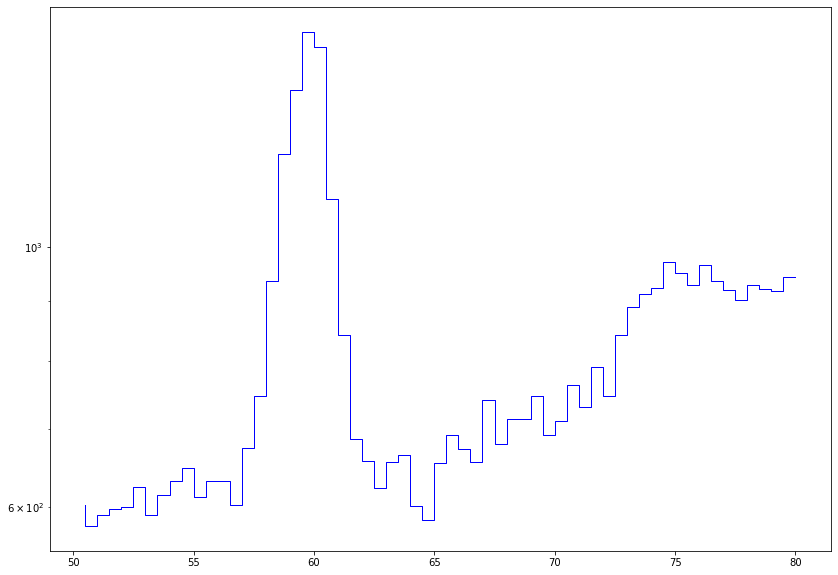

In [9]:
# Make energy spectrum
elo, ehi, epb = 50, 80, 0.5
# elo, ehi, epb = 0, 3000, 10
# elo, ehi, epb = 0, 6000, 10
        

nbx = int((ehi-elo)/epb)

energy_hist, bins = np.histogram(df['trapEftp_cal'], bins=nbx,
                range=[elo, ehi])

plt.semilogy(bins[1:], energy_hist, ds='steps', c='b', lw=1) #, label=f'{etype}'

# plt.xlabel(etype, ha='right', x=1)
# plt.ylabel('cts / sec', ha='right', y=1)
# # plt.legend()
# # plt.title(f'{etype}: {runtype} run {run} , {rt_min:.2f} mins')
# plt.savefig(f'./plots/normScan/{runtype}_energy_run{run}.pdf', dpi=200)
# plt.xlim(80000, 150000)
plt.show()

In [10]:
# Create a cut if appropriate
eCut_lo, eCut_hi = 30, 5500
dcr_lo, dcr_hi = 20, 125

cut_str = f'trapEftp_cal > {eCut_lo} and trapEftp_cal < {eCut_hi}' # and dcr_plot > {dcr_lo} and dcr_plot <{dcr_hi}

if cut == True:
    print(f'Using cut: {cut_str}')
    df_cut = df.query(cut_str).copy()
else:
    df_cut = df

Using cut: trapEftp_cal > 30 and trapEftp_cal < 5500


In [11]:
if norm==True:
    rt = np.array([(1/rt_min)])
    wts = np.repeat(rt, len(df_cut[etype]))
else:
    rt = np.array([(1/1.)])
    wts = np.repeat(rt, len(df_cut[etype]))

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-12-da06adc9987b>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())


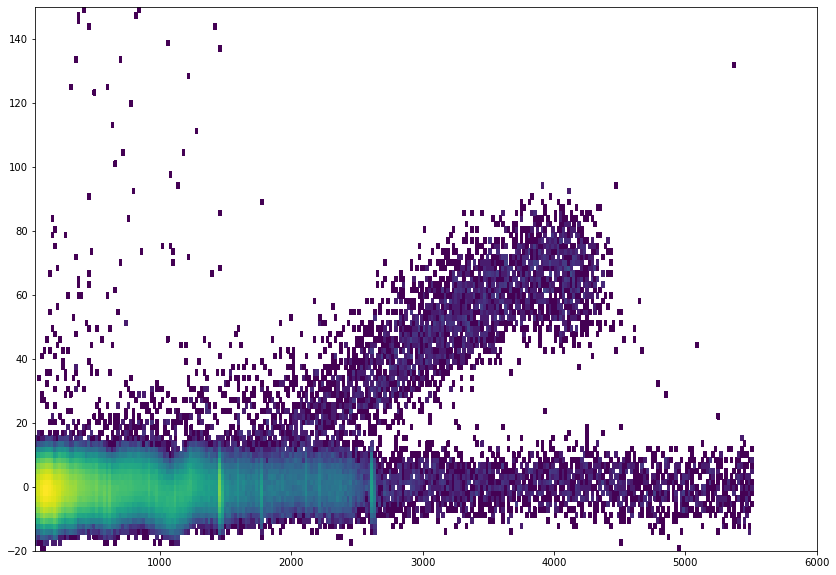

In [12]:
# %matplotlib widget


nb_dcr_corr = 100 #500
dlo_corr_norm, dhi_corr_norm = -20, 150
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_corr_vs_E_hist_norm, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_plot'], bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX, YY = np.mgrid[elo:ehi:nb_energy*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())
# plt.ylim(-20,20)
plt.show()

<ipython-input-13-bb52e6ae84a2>:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm = plt.pcolormesh(X, Y, aoe_hist_norm, norm=LogNorm(0.001, 0.1)) #0.002, 0.2


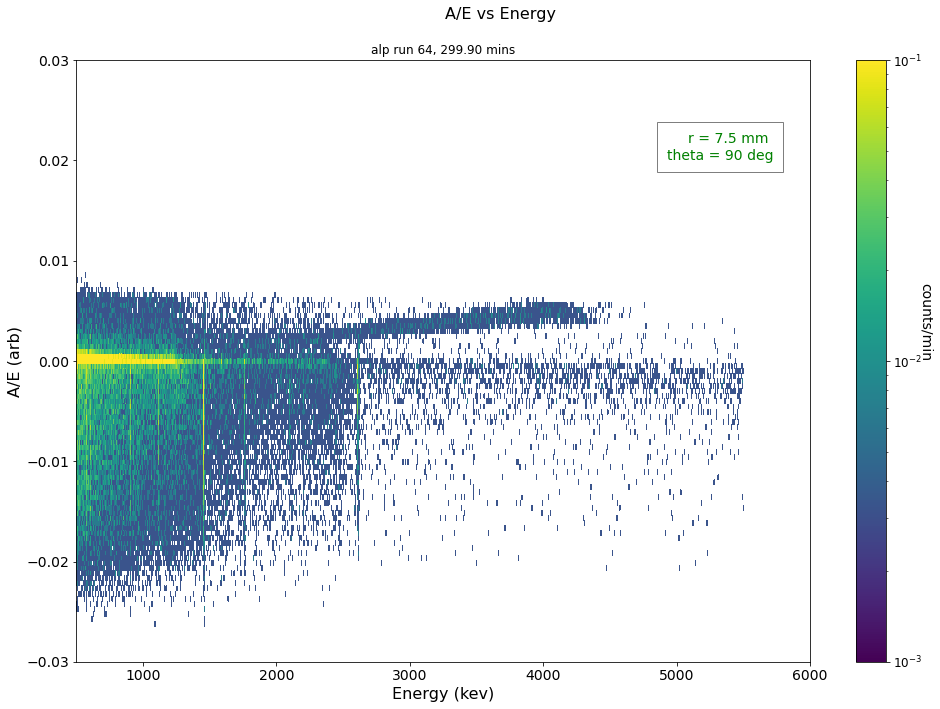

In [13]:
# normalized by runtime
fig, ax = plt.subplots()
alo, ahi, apb = 0.0, 0.09, 0.0001
if run>=36:
    alo, ahi, apb = 0.005, 0.075, 0.0001
if run>=117:
    alo, ahi, apb = 0.0, 0.15, 0.00015

if corr_AoE==True:
    alo, ahi, apb= -0.03, 0.03, 0.0005
    
elo, ehi, epb = 500, 6000, 1

wts = np.repeat(rt, len(df_cut[etype]))

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)

fig.suptitle(f'A/E vs Energy', horizontalalignment='center', fontsize=16)

aoe_hist_norm, xedges, yedges = np.histogram2d(df_cut[etype], df_cut['AoE_plot'], bins=[nbx, nby], range=([elo, ehi], [alo, ahi]), weights=wts)
X, Y = np.mgrid[elo:ehi:nbx*1j, alo:ahi:nby*1j]

#             aoe_hist_norm = np.divide(aoe_hist, (rt_min))

pcm = plt.pcolormesh(X, Y, aoe_hist_norm, norm=LogNorm(0.001, 0.1)) #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (kev)', fontsize=16)
ax.set_ylabel('A/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()

[0.00333445 0.00333445 0.00333445 ... 0.00333445 0.00333445 0.00333445]


<ipython-input-14-d42cfbdc7b02>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_AoE_hist_norm, norm=LogNorm())


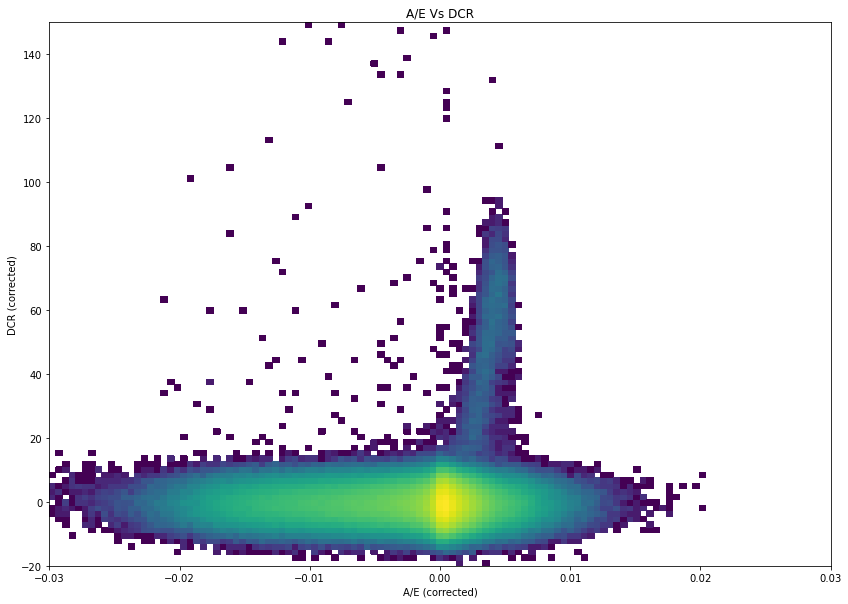

In [14]:
# %matplotlib widget


nb_dcr_corr = 100 #500
dlo_corr_norm, dhi_corr_norm = -20, 150

alo, ahi, apb = 0.0, 0.09, 0.0001
if run>=36:
    alo, ahi, apb = 0.005, 0.075, 0.0001
if run>=117:
    alo, ahi, apb = 0.0, 0.15, 0.00015

if corr_AoE==True:
    alo, ahi, apb= -0.03, 0.03, 0.0005
    
nbx = int((ahi-alo)/apb)

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_corr_vs_AoE_hist_norm, xedges, yedges = np.histogram2d(df_cut['AoE_plot'], df_cut['dcr_plot'], bins=[nbx, nb_dcr_corr], range=([alo, ahi], [dlo_corr_norm, dhi_corr_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX, YY = np.mgrid[alo:ahi:nbx*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_AoE_hist_norm, norm=LogNorm())
# plt.ylim(-20,20)
plt.title('A/E Vs DCR')
plt.xlabel('A/E (corrected)')
plt.ylabel('DCR (corrected)')
plt.show()

In [21]:

df_60['tp0020'] = df_60['tp_20'] - df_60['tp_0']
df_60['tp0030'] = df_60['tp_30'] - df_60['tp_0']
df_60['tp0050'] = df_60['tp_50'] - df_60['tp_0']
df_60['tp0205'] = df_60['tp_05'] - df_60['tp_02']
df_60['tp0210'] = df_60['tp_10'] - df_60['tp_02']
df_60['tp0220'] = df_60['tp_20'] - df_60['tp_02']
df_60['tp0250'] = df_60['tp_50'] - df_60['tp_02']
df_60['tp0510'] = df_60['tp_10'] - df_60['tp_05']
df_60['tp0520'] = df_60['tp_20'] - df_60['tp_05']
df_60['tp0550'] = df_60['tp_50'] - df_60['tp_05']

df_60['tp1090'] = df_60['tp_90'] - df_60['tp_10']
df_60['tp1096'] = df_60['tp_96'] - df_60['tp_10']

df_bkg['tp0020'] = df_bkg['tp_20'] - df_bkg['tp_0']
df_bkg['tp0030'] = df_bkg['tp_30'] - df_bkg['tp_0']
df_bkg['tp0050'] = df_bkg['tp_50'] - df_bkg['tp_0']
df_bkg['tp0205'] = df_bkg['tp_05'] - df_bkg['tp_02']
df_bkg['tp0210'] = df_bkg['tp_10'] - df_bkg['tp_02']
df_bkg['tp0220'] = df_bkg['tp_20'] - df_bkg['tp_02']
df_bkg['tp0250'] = df_bkg['tp_50'] - df_bkg['tp_02']
df_bkg['tp0510'] = df_bkg['tp_10'] - df_bkg['tp_05']
df_bkg['tp0520'] = df_bkg['tp_20'] - df_bkg['tp_05']
df_bkg['tp0550'] = df_bkg['tp_50'] - df_bkg['tp_05']

df_bkg['tp1090'] = df_bkg['tp_90'] - df_bkg['tp_10']
df_bkg['tp1096'] = df_bkg['tp_96'] - df_bkg['tp_10']

df_60['tp0230'] = df_60['tp_30'] - df_60['tp_02']
df_60['tp0530'] = df_60['tp_30'] - df_60['tp_05']
df_bkg['tp0230'] = df_bkg['tp_30'] - df_bkg['tp_02']
df_bkg['tp0530'] = df_bkg['tp_30'] - df_bkg['tp_05']

In [ ]:
tp_list = ['tp0205', 'tp0210', 'tp0220', 'tp0250', 'tp0510', 'tp0520', 'tp0550']

for tp in tp_list:
    print(tp)

Text(0.95, 0.83, 'r = 7.5 mm \ntheta = 90 deg \nruntime 299.90')

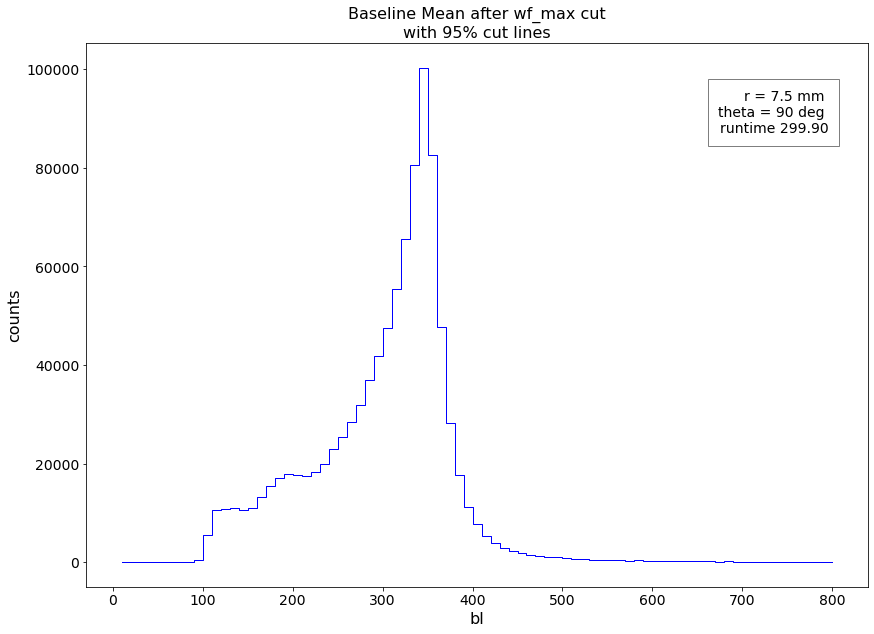

In [53]:
fig, ax = plt.subplots()
tlo, thi, tpb = 0, 800, 10
nbx = int((thi-tlo)/tpb)


tp0550_hist, bins = np.histogram(df['tp0550'], bins=nbx,
                range=[tlo, thi])

plt.plot(bins[1:], tp0550_hist, ds='steps', c='b', lw=1)



plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)

plt.title('Baseline Mean after wf_max cut\nwith 95% cut lines', fontsize = 16)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nruntime {rt_min:.2f}', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# if saveFig:
#     plt.savefig(f'./plots/{campaign}/run{run}_bl_mean.png', dpi=200)

Text(0.95, 0.83, 'r = 7.5 mm \ntheta = 90 deg \nruntime 299.90')

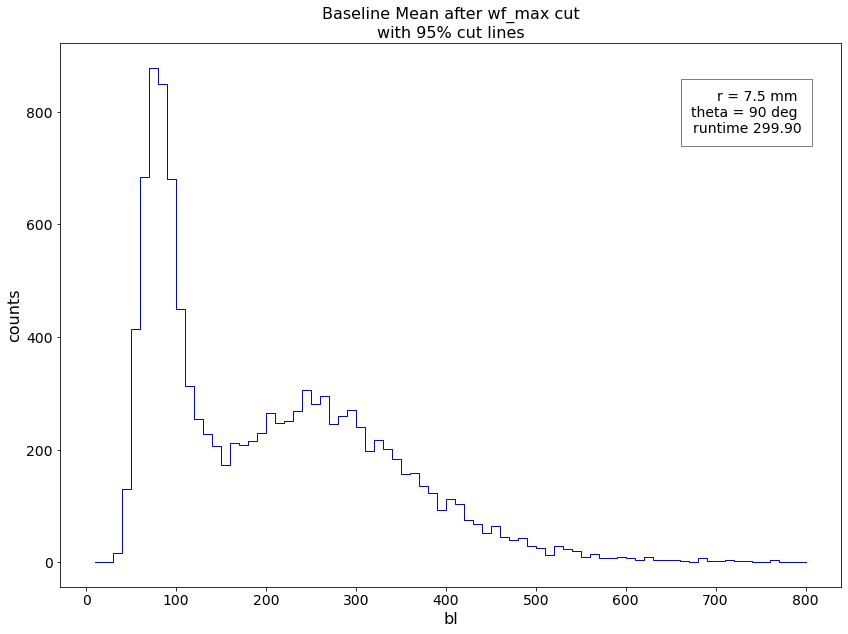

In [60]:
fig, ax = plt.subplots()
tlo, thi, tpb = 0, 800, 10
nbx = int((thi-tlo)/tpb)


tp0550_hist_60, bins = np.histogram(df_60['tp0220'], bins=nbx,
                range=[tlo, thi])

plt.plot(bins[1:], tp0550_hist_60, ds='steps', c='b', lw=1)



plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)

plt.title('Baseline Mean after wf_max cut\nwith 95% cut lines', fontsize = 16)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nruntime {rt_min:.2f}', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# if saveFig:
#     plt.savefig(f'./plots/{campaign}/run{run}_bl_mean.png', dpi=200)

Text(0.95, 0.83, 'r = 7.5 mm \ntheta = 90 deg \nruntime 299.90')

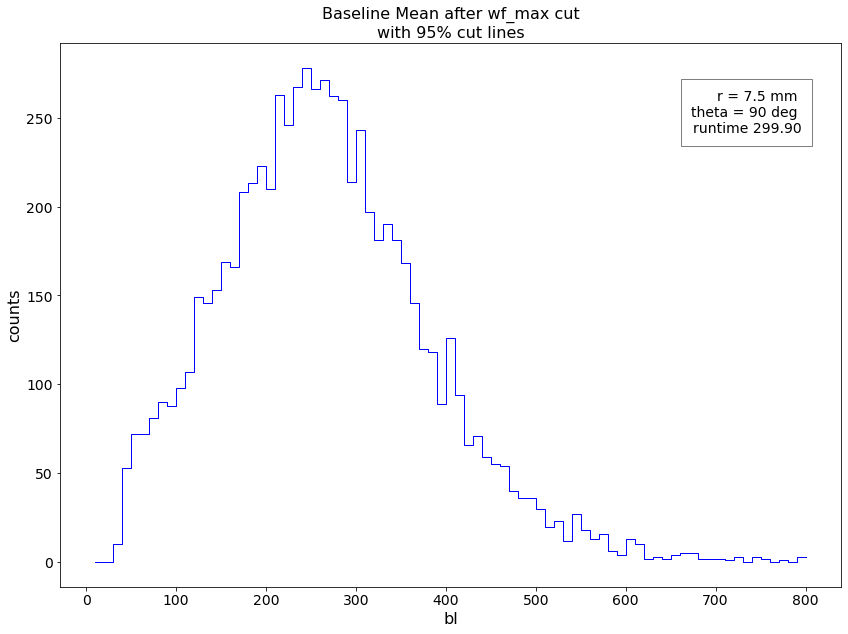

In [61]:
fig, ax = plt.subplots()
tlo, thi, tpb = 0, 800, 10
nbx = int((thi-tlo)/tpb)


tp0550_hist_bkg, bins = np.histogram(df_bkg['tp0220'], bins=nbx,
                range=[tlo, thi])

plt.plot(bins[1:], tp0550_hist_bkg, ds='steps', c='b', lw=1)



plt.xlabel('bl', fontsize=16)
plt.ylabel('counts', fontsize=16)

plt.title('Baseline Mean after wf_max cut\nwith 95% cut lines', fontsize = 16)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

ax.text(0.95, 0.83, f'r = {radius} mm \ntheta = {angle_det} deg \nruntime {rt_min:.2f}', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='black', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# if saveFig:
#     plt.savefig(f'./plots/{campaign}/run{run}_bl_mean.png', dpi=200)

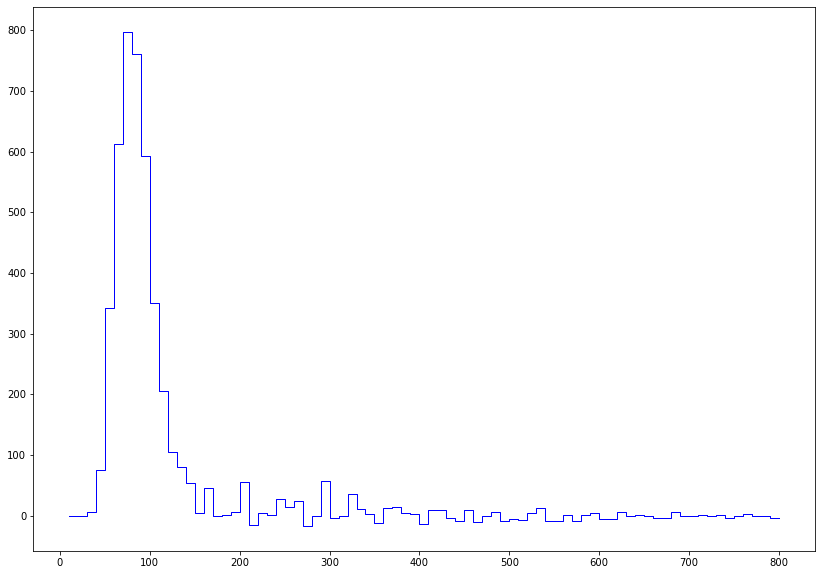

In [62]:
tp0550_hist_bkg_sub = tp0550_hist_60 - tp0550_hist_bkg
plt.plot(bins[1:], tp0550_hist_bkg_sub, ds='steps', c='b', lw=1)

In [ ]:
print(len(bins))

In [63]:
pars, cov = pgf.gauss_mode_width_max(tp0550_hist_bkg_sub, bins, n_bins = 5)
mode = pars[0]
width = pars[1]
amp = pars[2]
print(mode)

79.60168160626408


In [64]:

fit_pars, fit_cov = pgf.fit_hist(pgf.gauss_basic, tp0550_hist_bkg_sub, bins, guess = (mode, width, amp, 0))
# fit_pars, fit_cov = pgf.fit_hist(cage_utils.gauss_fit_func, tp0550_hist_bkg_sub, bins, guess = (amp, mode, width, 0))
print(fit_pars)

[ 79.60168161  18.92208985 812.08541832   0.        ]


/global/cfs/cdirs/majorana/projecta/majorana/users/gothman/joule_pygama/pygama/analysis/peak_fitting.py:56: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(var)[mask]
/global/homes/g/gothman/.local/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


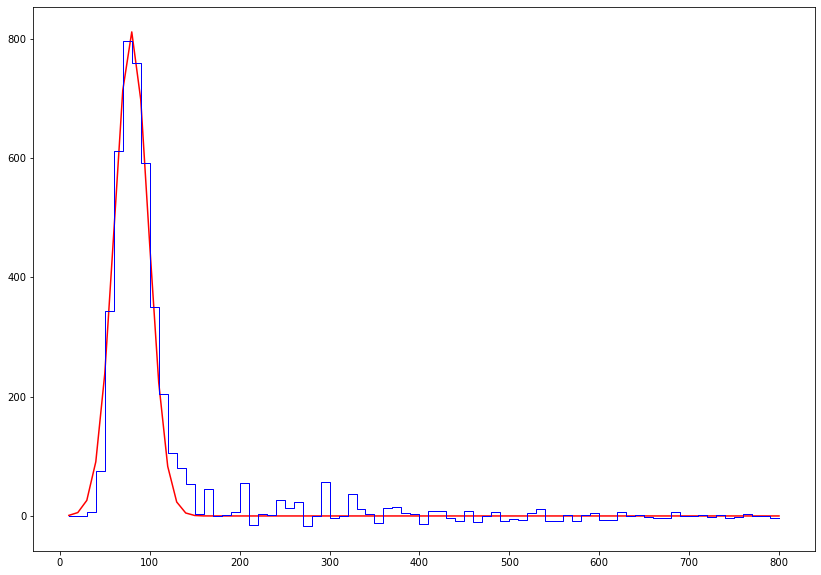

In [65]:
plt.plot(bins[1:], pgf.gauss_basic(bins[1:], *fit_pars), c = 'r')
# plt.plot(bins[1:], cage_utils.gauss_fit_func(bins[1:], *fit_pars), c = 'r')
plt.plot(bins[1:], tp0550_hist_bkg_sub, ds='steps', c='b', lw=1)
# plt.xlim(50, 150)

In [ ]:
quant = np.quantile(tp0550_hist_bkg_sub, q = (0.5, .96))
print(quant)

In [ ]:
mean = fit_pars[0]
sig = fit_pars[1]

In [ ]:
def myround(x, base=5):
    return base * round(x/base)

In [ ]:
max_test = np.argmax(tp0550_hist_bkg_sub)
test = np.digitize([mode], bins)
max_ar = np.amax(tp0550_hist_bkg_sub)

print(f'argmax: {max_test}')
print(test)
print(max_ar)
print(max_test, test)
print(tp0550_hist_bkg_sub[test[0]-1])

In [ ]:
tp_hist_bkg_sub_clip = tp0550_hist_bkg_sub.clip(min=0.0)
bin_centers = pgh.get_bin_centers(bins)

print(bins)
            
cut_3sig_lo = mean-3*sig
cut_3sig_hi = mean+3*sig

# cut_3sig_lo = myround(cut_3sig_lo)
# cut_3sig_hi = myround(cut_3sig_hi)
cuts = [cut_3sig_lo, cut_3sig_hi]
test = np.digitize(cuts, bins)

print(test)

print(cut_3sig_lo, cut_3sig_hi)
            
# idx_lo = np.argwhere(bin_centers == cut_3sig_lo)[0][0]
# idx_hi = np.argwhere(bin_centers == cut_3sig_hi)[0][0]

idx_lo = test[0]-1
idx_hi = test[1]

print(idx_lo, idx_hi)
            
counts = np.sum(tp_hist_bkg_sub_clip[idx_lo:idx_hi])

print(counts)

In [ ]:
print(tp_hist_bkg_sub_clip[idx_lo])
print(tp_hist_bkg_sub_clip[idx_hi-1])
print(tp_hist_bkg_sub_clip[idx_lo:idx_hi])

In [ ]:
tp_hi = [10, 20, 30, 40, 50, 60, 70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp00{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 3000, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.ylim(0, 125)
    plt.xlim(0,500)
    plt.show()

In [ ]:
tp_hi = [10, 20]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp02{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
#     plt.xlim(0,500)
#     plt.ylim(0, 50)
    plt.show()

In [ ]:
tp_hi = [10, 20]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp02{t}')
print(tp_param_list)

for tp_param in tp_param_list:

    elo, ehi = 50, 5500
    e_bins = int((ehi - elo )/10)

    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    EvsTP_hist_norm, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut[f'{tp_param}'], bins=[e_bins, t_bins], range=([elo, ehi], [tlo, thi]), weights=wts)
    X, Y = np.mgrid[elo:ehi:e_bins*1j, tlo:thi:t_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, EvsTP_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel('trapEftp_cal', fontsize=16)
    ax.set_ylabel(f'{tp_param}(arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
#     plt.xlim(0,500)
    plt.show()

In [ ]:
tp_hi = [10, 20]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp02{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    slo, shi, spb = -5.5e-5, -4.5e-5, 10
    s_bins = 50
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['log_tail_fit_slope'], bins=[t_bins, s_bins], range=([tlo, thi], [slo, shi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, slo:shi:s_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
#     plt.xlim(0,500)
#     plt.ylim(0, 50)
    plt.show()

In [ ]:
tp_hi = [10, 20]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp05{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
#     plt.xlim(0, 100)
    plt.show()

In [ ]:
tp_hi = [20, 30] #, 40, 50, 60, 70, 80, 90, 96
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp10{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [30, 40, 50, 60, 70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp20{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [40, 50, 60, 70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp30{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [50, 60, 70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp40{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [60, 70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp50{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [70, 80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp60{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [80, 90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp70{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
tp_hi = [90, 96]
tp_param_list = []
for t in tp_hi:
    tp_param_list.append(f'tp80{t}')
print(tp_param_list)

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:

tp_param_list = ['tp9096']

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVdcr_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['dcr_plot'], bins=[t_bins, d_bins], range=([tlo, thi], [dlo, dhi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, dlo:dhi:d_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVdcr_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:

tp_param_list = ['tp9096']

for tp_param in tp_param_list:
    if run>=36 and run<117:
        dlo, dhi = -40, 170
        d_bins = 200
    elif run>=117:
        # dlo, dhi, dpb = -20., 40, 0.1
        dlo, dhi = -40, 170
        d_bins = 200
    fig, ax = plt.subplots()   
    tlo, thi, tpb = 0, 500, 10
    t_bins = int((thi-tlo)/tpb)
    fig.suptitle(f'\nDCR vs {tp_param}', horizontalalignment='center', fontsize=16)
    tpVtp_hist_norm, xedges, yedges = np.histogram2d(df_cut[f'{tp_param}'], df_cut['tp0210'], bins=[t_bins,t_bins], range=([tlo, thi], [tlo, thi]), weights=wts)
    X, Y = np.mgrid[tlo:thi:t_bins*1j, tlo:thi:t_bins*1j]
    
    pcm = plt.pcolormesh(X, Y, tpVtp_hist_norm, norm=LogNorm(0.001, 10))
    cb = plt.colorbar()
    cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
    cb.ax.tick_params(labelsize=12)
    ax.set_xlabel(f'{tp_param}(arb)', fontsize=16)
    ax.set_ylabel('DCR (arb)', fontsize=16)
    plt.setp(ax.get_xticklabels(), fontsize=12)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    plt.show()

In [ ]:
cut_tp0210 = f'tp0210 > 0 and tp0210 < 150'
cut2_tp0210 = f'tp0210 > 300 and tp0210 < 375'
df_0210 = df_cut.query(cut_tp0210).copy()
print(len(df_0210['trapEftp_cal']))
# times, superpulse_tp0210 = cage_utils.get_superpulse(df_cut2, dg, cut_tp0210, all=True, norm=True)
# times, superpulse_outlier= cage_utils.get_superpulse(df_cut2, dg, cut2_tp0210, all=True, norm=True)

In [ ]:
# %matplotlib widget


nb_dcr_corr = 100 #500
dlo_corr_norm, dhi_corr_norm = -20, 150
nb_energy = 299 #599
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_cut['trapEftp_cal']))
print(wts)

dcr_corr_vs_E_hist_norm, xedges, yedges = np.histogram2d(df_cut['trapEftp_cal'], df_cut['dcr_plot'], bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX, YY = np.mgrid[elo:ehi:nb_energy*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())
# plt.ylim(-20,20)
plt.show()

In [ ]:
# %matplotlib widget


nb_dcr_corr = 100 #500
dlo_corr_norm, dhi_corr_norm = -20, 150
nb_energy = 299 #599 #5950
elo = 50
ehi = 6000

#normalize hist by runtime
rt = np.array([(1/rt_min)])
wts = np.repeat(rt, len(df_0210['trapEftp_cal']))
print(wts)

dcr_corr_vs_E_hist_norm, xedges, yedges = np.histogram2d(df_0210['trapEftp_cal'], df_0210['dcr_plot'], bins=[nb_energy, nb_dcr_corr], range=([elo, ehi], [dlo_corr_norm, dhi_corr_norm]), weights=wts)

# dcr_corr_vs_E_hist_norm = np.divide(dcr_corr_vs_E_hist, rt_min)

XX, YY = np.mgrid[elo:ehi:nb_energy*1j, dlo_corr_norm:dhi_corr_norm:nb_dcr_corr*1j]

pcm1 = plt.pcolormesh(XX, YY, dcr_corr_vs_E_hist_norm, norm=LogNorm())
# plt.ylim(-20,20)
# plt.xlim(50,80)
plt.show()

In [ ]:
dcr_cut = f'dcr_plot > 10 and dcr_plot < 125'
df_alphaCut = df_0210.query(dcr_cut).copy()
print(len(df_alphaCut['trapEftp_cal']))

In [ ]:
df_dcrCut = df_cut.query(dcr_cut).copy()
print(len(df_dcrCut['trapEftp_cal']))

In [ ]:
# df_alphaCut = df.query(f'{toe_cut_str} and dcr > {dcrCut_lo} and dcr < {dcrCut_hi}').copy()
wts_alphaCut = np.repeat(rt, len(df_alphaCut[etype]))

In [ ]:
# normalized by runtime
fig, ax = plt.subplots()
alo, ahi, apb = 0.0, 0.09, 0.0001
if run>=36:
    alo, ahi, apb = 0.005, 0.075, 0.0001
if run>=117:
    alo, ahi, apb = 0.0, 0.15, 0.00015

if corr_AoE==True:
    alo, ahi, apb= -0.03, 0.03, 0.0005
    
elo, ehi, epb = 500, 6000, 1

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)
events = len(df_dcrCut['trapEftp_cal'])

wts = np.repeat(rt, len(df_dcrCut[etype]))

fig.suptitle(f'A/E vs Energy \nDCR cut only', horizontalalignment='center', fontsize=16)

cut_aoe_hist_norm, xedges, yedges = np.histogram2d(df_dcrCut[etype], df_dcrCut['AoE_plot'], bins=[nbx, nby], range=([elo, ehi], [alo, ahi]), weights=wts)
X, Y = np.mgrid[elo:ehi:nbx*1j, alo:ahi:nby*1j]

#             aoe_hist_norm = np.divide(aoe_hist, (rt_min))

pcm = plt.pcolormesh(X, Y, cut_aoe_hist_norm, norm=LogNorm(0.001, 0.1)) #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (kev)', fontsize=16)
ax.set_ylabel('A/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'{events} events passing cut \nr = {radius} mm \ntheta = {angle_det} deg', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()

In [ ]:
# normalized by runtime
fig, ax = plt.subplots()
alo, ahi, apb = 0.0, 0.09, 0.0001
if run>=36:
    alo, ahi, apb = 0.005, 0.075, 0.0001
if run>=117:
    alo, ahi, apb = 0.0, 0.15, 0.00015

if corr_AoE==True:
    alo, ahi, apb= -0.03, 0.03, 0.0005
    
elo, ehi, epb = 500, 6000, 1

nbx = int((ehi-elo)/epb)
nby = int((ahi-alo)/apb)
events = len(df_alphaCut['trapEftp_cal'])

fig.suptitle(f'A/E vs Energy \nDCR and tp0210 cuts', horizontalalignment='center', fontsize=16)

cut_aoe_hist_norm, xedges, yedges = np.histogram2d(df_alphaCut[etype], df_alphaCut['AoE_plot'], bins=[nbx, nby], range=([elo, ehi], [alo, ahi]), weights=wts_alphaCut)
X, Y = np.mgrid[elo:ehi:nbx*1j, alo:ahi:nby*1j]

#             aoe_hist_norm = np.divide(aoe_hist, (rt_min))

pcm = plt.pcolormesh(X, Y, cut_aoe_hist_norm, norm=LogNorm(0.001, 0.1)) #0.002, 0.2

cb = plt.colorbar()
cb.set_label("counts/min", ha = 'right', va='center', rotation=270, fontsize=14)
cb.ax.tick_params(labelsize=12)
ax.set_xlabel(f'Energy (kev)', fontsize=16)
ax.set_ylabel('A/E (arb)', fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)


ax.text(0.95, 0.83, f'{events} events passing cut \nr = {radius} mm \ntheta = {angle_det} deg', verticalalignment='bottom',
            horizontalalignment='right', transform=ax.transAxes, color='green', fontsize=14, bbox={'facecolor': 'white', 'alpha': 0.5, 'pad': 10})

# plt.legend()
plt.title(f'\n{runtype} run {run}, {rt_min:.2f} mins', fontsize=12)
plt.tight_layout()